# Model building

Having explored the data a bit in 'DOTA 2 Data Exploration.ipynb', I'd like to try and build a model that predicts whether I won or lost each match.

Let's start by importing the dataset we created earlier.

In [8]:
import pandas as pd
from pathlib import Path

base_directory = Path('C:/Users/Ryan/dota2-classification')

df = pd.read_csv(base_directory / 'dataset.csv')

df.head()

,assists,deaths,duration,game_mode,hero_id,kills,leaver_status,lobby_type,match_id,player_slot,radiant_win,start_time,hero_name,start_datetime,team,win
0,18,4,2533,22,27,7,0,0,3587558457,2,True,1511879974,Shadow Shaman,2017-11-28 14:39:34,radiant,1
1,5,6,2375,22,18,5,0,0,3434506769,128,True,1504985730,Sven,2017-09-09 19:35:30,dire,0
2,1,2,2112,22,31,1,1,0,3434469722,129,True,1504984250,Lich,2017-09-09 19:10:50,dire,0
3,19,5,3074,5,75,15,0,0,3433444310,0,True,1504953922,Silencer,2017-09-09 10:45:22,radiant,1
4,16,1,2816,22,29,3,0,0,3432206454,131,True,1504897425,Tidehunter,2017-09-08 19:03:45,dire,0


# Data Cleaning

Before I start building the model, I'm going to remove a few columns that I believe won't be useful for predicting victory.

In [9]:
df = df.drop(columns = ['game_mode', 'hero_id', 'lobby_type', 'match_id', 'player_slot', 'radiant_win', 'start_time', 'start_datetime'], axis = 1)

df.head()

,assists,deaths,duration,kills,leaver_status,hero_name,team,win
0,18,4,2533,7,0,Shadow Shaman,radiant,1
1,5,6,2375,5,0,Sven,dire,0
2,1,2,2112,1,1,Lich,dire,0
3,19,5,3074,15,0,Silencer,radiant,1
4,16,1,2816,3,0,Tidehunter,dire,0


I'm also going to remove rows where *leaver_status* = 1. This represents a game where one player has left before the match ended, and the game is therefore 'abandoned'. I'll also remove the column after that since it is just a column of zeroes now

In [10]:
df = df[df['leaver_status'] == 0]

df = df.drop(columns = 'leaver_status', axis = 1)

df.head()

,assists,deaths,duration,kills,hero_name,team,win
0,18,4,2533,7,Shadow Shaman,radiant,1
1,5,6,2375,5,Sven,dire,0
3,19,5,3074,15,Silencer,radiant,1
4,16,1,2816,3,Tidehunter,dire,0
5,19,2,2513,6,Gyrocopter,dire,1


We're now left with 6 useful columns to try and predict victory:
1. *assists* - how many times you assisted in killing an enemy hero
2. *deaths* - how many times you died
3. *duration* - length of the match in seconds
4. *kills* - how many times you killed an enemy hero
5. *hero_name* - which hero you were playing
6. *team* - which side (radiant or dire) you were playing on (radiant generally has a small win rate advantage to the tune of ~2%, as you can see below)

Note: Look how close to 50% the win rate is - turns out DOTA matches are quite ideal for modelling due to very little imbalance!

In [11]:
df.groupby('team').agg({'win':'mean'})

,win
team,
dire,0.510768
radiant,0.536780


In terms of model selection, I will start with a simple logistic regression to get a benchmark of what kind of performance we can expect from this data, before trying some more advanced models.

# Logistic Regression

In [12]:
#splitting into features (X) and labels (y)
X = df[['hero_name', 'kills', 'deaths', 'assists', 'duration', 'team']]
y = df['win']

#splitting into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Due to the presence of categorical variables (features *hero_name* and *team*), we'll need to encode these features somehow.

I generally stick to 3 types of encoding, and use the best for each model/dataset:
1. One Hot Encoding - turns each level of a column into a dummy variable
2. Label Encoding - turns each level of a column into a different number
3. Target Encoding - turns each level of a column into the mean of the outcome for rows within that level

I cannot use One Hot Encoding here due to the number of different heroes in DOTA 2 (115 currently! Which would result in 114 new columns being created!)

Label Encoding I also generally dislike - models can assume ordinality from the numbers created, leading to bad performance on test sets

Therefore we will encode the categorical variables using Target Encoding

In [14]:
import category_encoders as ce
#create the encoder with the 2 categorical columns
encoder = ce.TargetEncoder(cols = ['hero_name', 'team'])

#fit the encoder on the train set
encoder.fit(X_train, y_train)

#transform both train and test sets
#very important not to train the encoder on any test data - will result in leakage and misleading performance
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

X_test.head()

,hero_name,kills,deaths,assists,duration,team
3665,0.675676,1,5,4,1868,0.546030
3715,0.483871,8,1,4,1498,0.546030
492,0.480000,4,11,15,2487,0.529061
925,0.423077,2,4,14,2407,0.546030
3022,0.357143,10,2,21,2087,0.529061


Our categorical features have now been encoded into floats, so we can start training a model!

In [19]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(solver = 'liblinear', random_state = 42)
reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Model trained, let's see how it performed

In [20]:
print(f'Mean accuracy of train set = {reg.score(X_train, y_train)}')
print(f'Mean accuracy of test set = {reg.score(X_test, y_test)}')

Mean accuracy of train set = 0.8155515370705244
Mean accuracy of test set = 0.8091106290672451


Okay! Not a bad accuracy! The fact that the test set is performing similarly to the train set tells me that there isn't a great deal of overfitting going on. This is a fairly balanced dataset, so I don't think a ROC score will give us much more information, but it's worth a look.

ROC score of train set = 0.8915720279985224
ROC score of test set = 0.8846913056792217


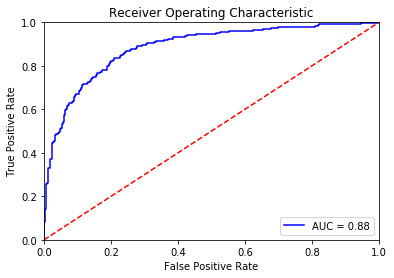

In [40]:
train_predictions = reg.predict_proba(X_train)[:,1]
test_predictions = reg.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score
print(f'ROC score of train set = {roc_auc_score(y_true = y_train, y_score = train_predictions)}')
print(f'ROC score of test set = {roc_auc_score(y_true = y_test, y_score = test_predictions)}')

from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_test, test_predictions)
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As expected, ROC scores of train and test set are similar too!

Let's see if we can improve that score a bit with a different model - a random forest is quick and fairly powerful!

# Random Forest

I'll give it a go with an out-of-the-box random forest, and then do some CV grid searching for hyperparameter tuning.

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42, n_estimators = 10)

rf.fit(X_train, y_train)

rf_predictions_train = rf.predict_proba(X_train)[:,1]
rf_predictions_test = rf.predict_proba(X_test)[:,1]

print(f'RF ROC score of train set = {roc_auc_score(y_true = y_train, y_score = rf_predictions_train)}')
print(f'RF ROC score of test set = {roc_auc_score(y_true = y_test, y_score = rf_predictions_test)}')

RF ROC score of train set = 0.9990725568384529
RF ROC score of test set = 0.860909711916708


Interesting! With the random forest we have near-perfect performance on the train set, but worse performance on the test set. This indicates the existence of overfitting in our model - the model has learnt the train set *too* well, and as a result is not performing well on the test set.

Let's try doing some CV randomised grid searches to reduce that overfitting, and increase our test performance.

I'll first create a grid for the search (note I'm starting n_estimators fairly low due to our need to reduce overfitting - a lot of trees can be associated with overfitting)

In [38]:
#CV and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='roc_auc',
                              cv = 3, verbose=5, random_state=142, n_jobs=-1,
                              iid=True)

# Fit the random search model
rf_random.fit(X_train, y_train)

#check best parameters
rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=44,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Okay, our grid search has produced a set of best parameters for our dataset. I'm surprised that it has chosen such a high number of trees (44) due to us seeing overfitting with only 10 trees.

Let's retrain our model with these parameters and see if our performance has improved.

In [39]:
rf = rf_random.best_estimator_

rf.fit(X_train, y_train)

CVrf_predictions_train = rf.predict_proba(X_train)[:,1]
CVrf_predictions_test = rf.predict_proba(X_test)[:,1]

print(f'RF ROC score of train set = {roc_auc_score(y_true = y_train, y_score = CVrf_predictions_train)}')
print(f'RF ROC score of test set = {roc_auc_score(y_true = y_test, y_score = CVrf_predictions_test)}')

RF ROC score of train set = 0.9516335102447607
RF ROC score of test set = 0.8922290533060091


Woop! The grid search has reduced our overfitting, and increased our test performance at the same time (only by 1% over the logistic regression though!).

Let's have a look at the ROC curve

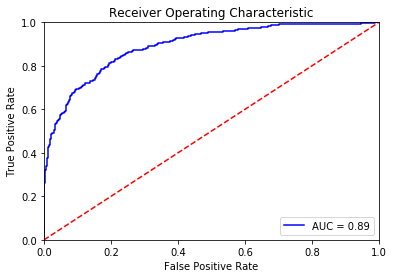

In [45]:
fpr, tpr, threshold = roc_curve(y_test, CVrf_predictions_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Even though there is a performance increase, if I were to deploy this for use I would still strongly consider using the logistic regression over the random forest. Explainability and relative simplicity can be incredibly valuable when things go wrong.